<a href="https://colab.research.google.com/github/Pyeonseohee/Deeplearning/blob/main/Deepnoid_Lecture06_U-Net_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/images/segmentation?hl=ko

다음 예제는 텐서플로우 공식 홈페이지 예제를 바탕으로 수정한 가천대학교 U-Net 실습 입니다.

먼저 tensorflow 환경을 셋팅합니다

In [1]:

!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-mnmr3eqb
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-mnmr3eqb
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ee198ec873148a5df3fd6eedb8d396613164ead7_-cp36-none-any.whl size=215217 sha256=c5ce5b9afccf12cbcca27b49f5d618609f46af5fe22a30b315a8f7a30b94898b
  Stored in directory: /tmp/pip-ephem-wheel-cache-urtnpsom/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
     |████████████████████████████████| 3.8MB 10.6MB/s 


In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

이번 튜토리얼에 사용 될 데이터 세트는 Parkhi et al이 만든 Oxford-IIIT Pet Dataset입니다. 데이터 세트는 영상, 해당 레이블과 픽셀 단위의 마스크로 구성됩니다. 마스크는 기본적으로 각 픽셀의 레이블입니다. 각 픽셀은 다음 세 가지 레이블 중 하나가 주어집니다:

class 1 : 애완동물이 속한 픽셀
class 2 : 애완동물과 인접한 픽셀
class 3 : 위에 속하지 않는 경우/주변 픽셀

Oxford-IIIT Pets 데이터 셋 다운로드하기
데이터 세트는 이미 텐서플로 데이터 세트에 포함되어 있으며, 다운로드만 하면 됩니다. 분할 마스크는 버전 3+에 포함되어 있습니다.

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


다음 코드는 이미지를 float32로 변환 후, 영상이 [0,1]로 정규화됩니다. 마지막으로, 위에서 언급한 것처럼 분할 마스크의 픽셀에 {1, 2, 3}이라는 레이블이 붙습니다. 편의성을 위해 분할 마스크에서 1을 빼서 레이블이 {0, 1, 2}이 되도록 합시다.

In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

다음은 train image를 load하는 과정입니다.
데이터의 크기를 128 by 128로 맞춰 줍니다
50%의 확률로 flip을 시켜줍니다.
normalize를 시킵니다.

In [6]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

다음은 test image를 load하는 과정입니다. 데이터의 크기를 128 by 128로 맞춰 줍니다. train image와는 달리 flip과정은 생략합니다. normalize를 시킵니다.



In [7]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

데이터 학습 준비
train set과 test set을 나눈다
batch size = 64


In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Data set에 사용하는 이미지와 마스트 확인

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

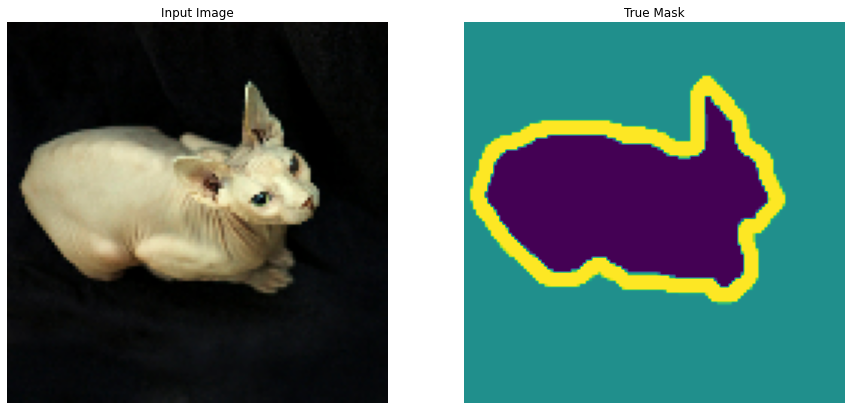

In [14]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

모델 정의하기

여기서 사용하는 모델은 U-Net입니다. U-Net은 인코더(다운샘플러)와 디코더(업샘플러)를 포함합니다. 

기존 튜토리얼상 Unet 모델은 MobileNetV2을 backbone으로 사용했지만, 내부 convolution 단을 확인하기 어렵고, 처음 U-Net을 구현한다 가정하고 일단 기본 U-Net 구조로 실습을 진행할 예정입니다.

3개의 채널을 출력하는 이유는 픽셀당 3개의 가능한 라벨이 있기 때문입니다. 이것을 각 화소가 세 개의 class로 분류되는 다중 분류라고 생각하세요.

weight 초기화는 He normalization을 사용
Xaiver initializer가 ReLu 함수 사용시 출력 값이 0으로 수렴하는 문제 해결 https://reniew.github.io/13/
dropout 0.3

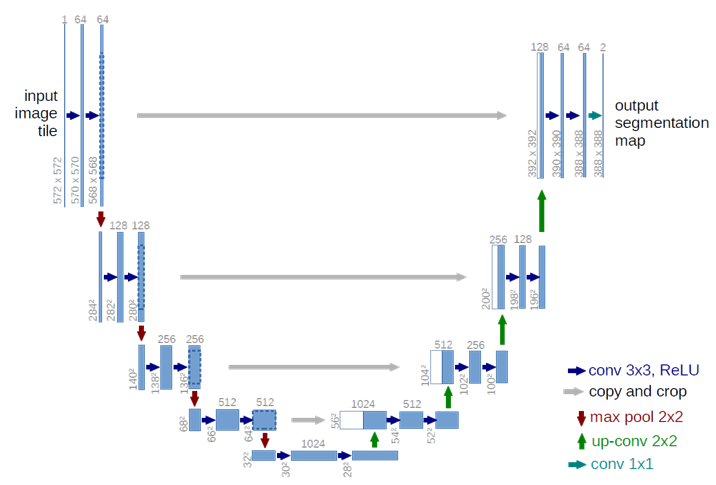


In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def Unet( output_channels = 3):

    hn = tf.keras.initializers.HeNormal()
    dropout = 0.3
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    conv1 = tf.keras.layers.Conv2D(32, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(inputs)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(conv1)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(pool1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(conv2)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(pool2)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(conv3)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(pool3)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(conv4)
    drop4 = tf.keras.layers.Dropout(dropout)(conv4)
    pool4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(512, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(pool4)
    conv5 = tf.keras.layers.Conv2D(512, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(conv5)
    drop5 = tf.keras.layers.Dropout(dropout)(conv5)
    up6 = tf.keras.layers.Conv2D(256, 2, activation= 'relu', padding = 'same', kernel_initializer = hn)(tf.keras.layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(256, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(merge6)
    conv6 = tf.keras.layers.Conv2D(256, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(conv6)
    up7 = tf.keras.layers.Conv2D(128, 2, activation= 'relu', padding = 'same', kernel_initializer = hn)(tf.keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(merge7)
    conv7 = tf.keras.layers.Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(conv7)
    up8 = tf.keras.layers.Conv2D(64, 2, activation= 'relu', padding = 'same', kernel_initializer = hn)(tf.keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(merge8)
    conv8 = tf.keras.layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(conv8)
    up9 = tf.keras.layers.Conv2D(32, 2, activation= 'relu', padding = 'same', kernel_initializer = hn)(tf.keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(32, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(merge9)
    conv9 = tf.keras.layers.Conv2D(32, 3, activation= 'relu', padding = 'same', kernel_initializer = hn)(conv9)

    conv10 = tf.keras.layers.Conv2D(output_channels, (1, 1), activation= 'softmax')(conv9)

    return tf.keras.Model(inputs=inputs, outputs=conv10)

In [17]:
model = Unet(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

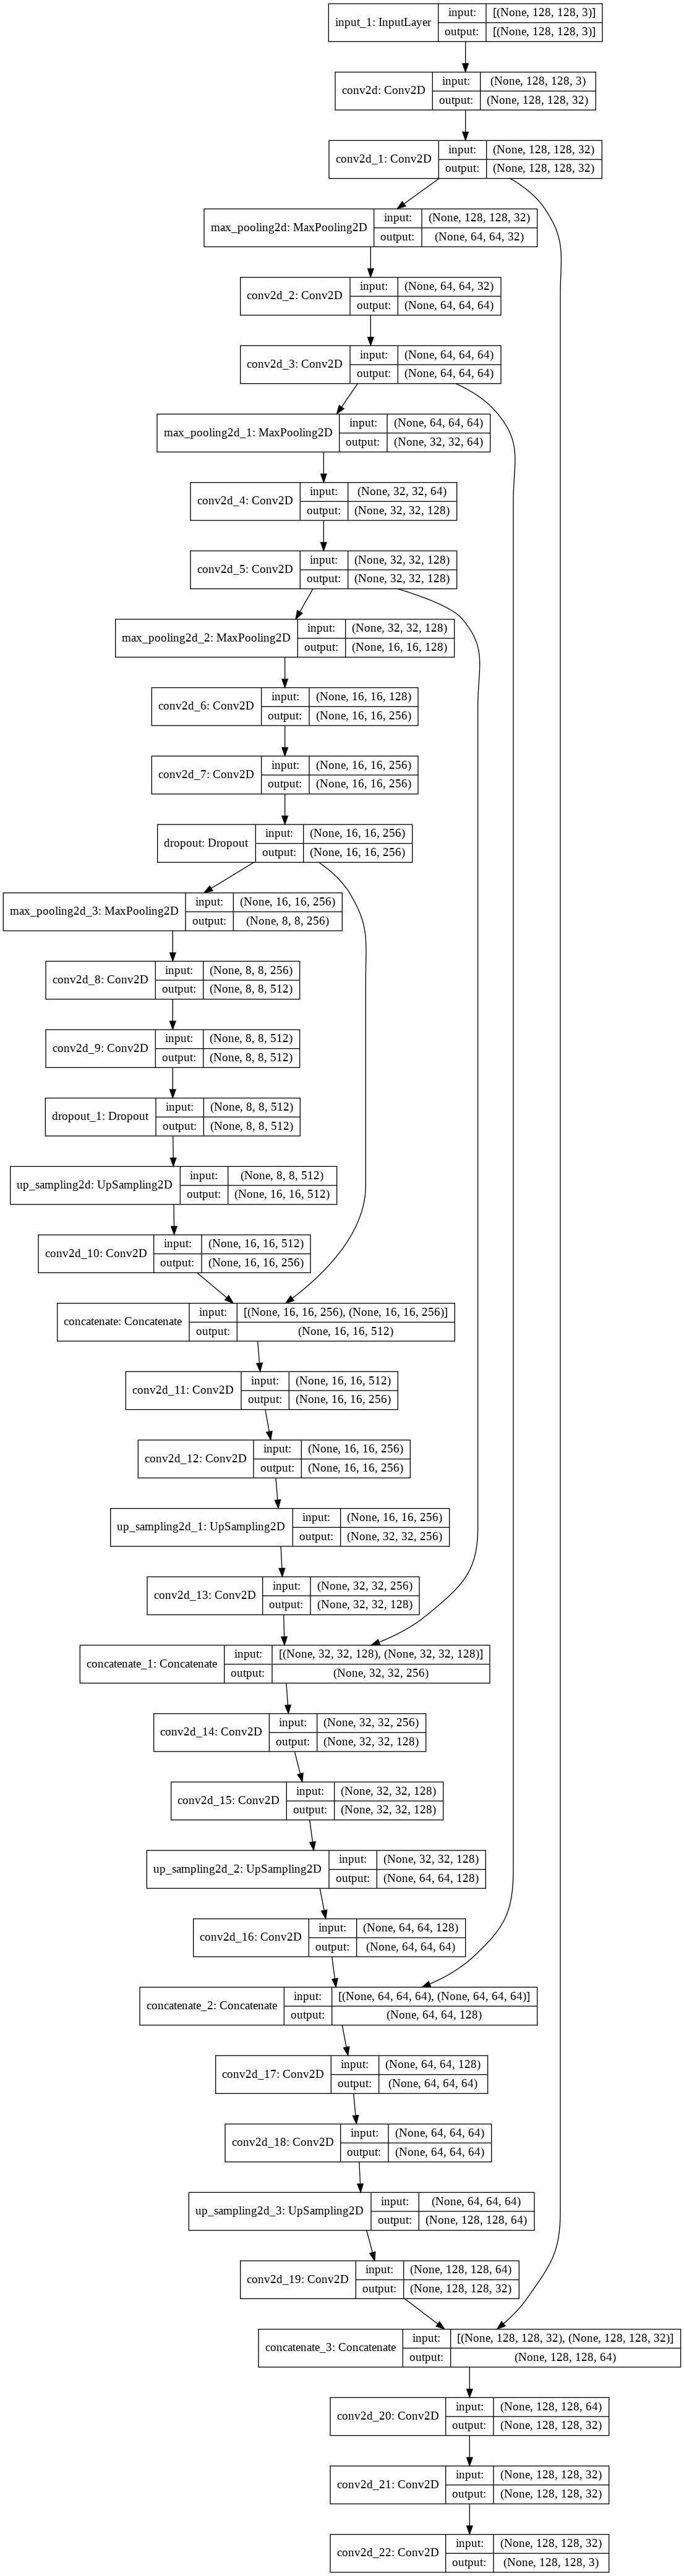

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

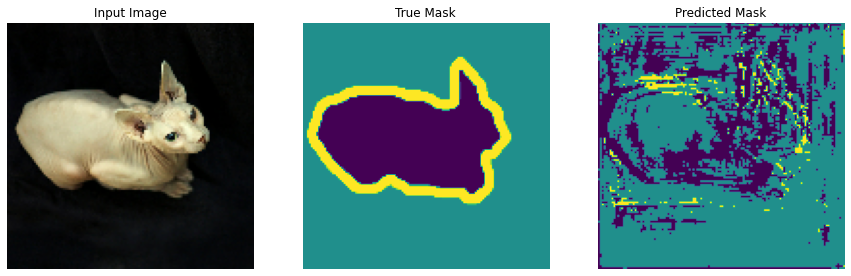

In [21]:
show_predictions()

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

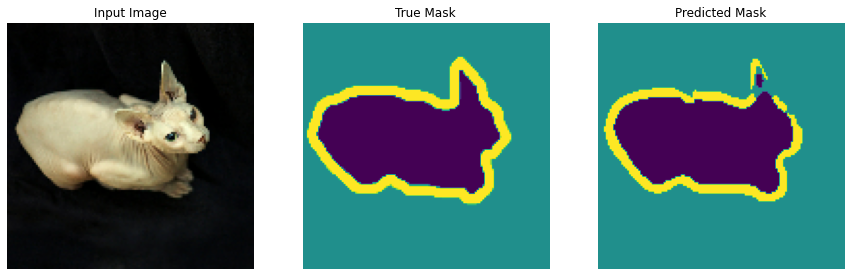


에포크 이후 예측 예시 20



In [24]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

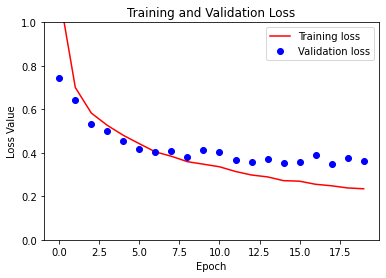

In [25]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

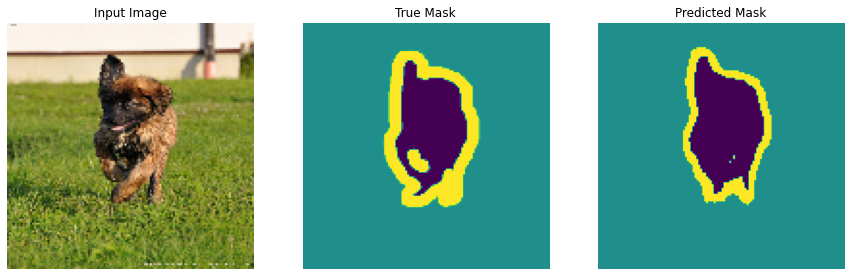

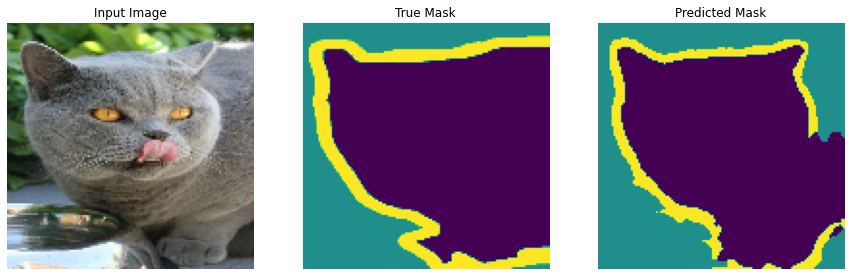

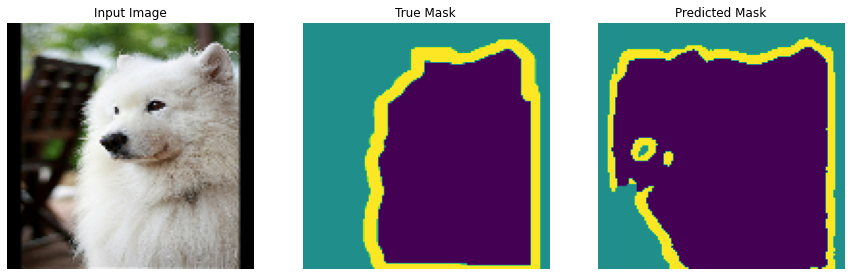

In [26]:
show_predictions(test_dataset, 3)